In [1]:
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/tmp/ipykernel_57943/1641497881.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
from mne.datasets import fetch_fsaverage

print(__doc__)

# paths to mne datasets - sample sEEG and FreeSurfer's fsaverage subject
# which is in MNI space
misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()

In [ ]:
subject = 'fsaverage'
subjects_dir = '/root/mne_data/MNE-sample-data' + '/subjects'

# use mne-python's fsaverage data
fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # downloads if needed

In [2]:
path= '/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/pte6_1_28_38.edf'

# first we'll load in the sample dataset
raw = mne.io.read_raw_edf(path)

# drop bad channels
#raw.info['bads'].extend([ch for ch in raw.ch_names if ch not in ch_names])
raw.load_data()
raw.drop_channels(raw.info['bads'])

Extracting EDF parameters from /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/pte6_1_28_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2764799  =      0.000 ... 10799.996 secs...


Measurement date,"November 10, 2022 00:57:15 GMT"
Experimenter,Unknown
Participant,Heidy
Digitized points,Not available
Good channels,130 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.15 Hz
Lowpass,67.00 Hz


In [41]:
# In mne-python, the electrode coordinates are required to be in meters
elec_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EpiPlanner/pte06/DataP06/P_06_ELEC_LOC.tsv',
                      sep='\t', header=0, index_col=None)
ch_names = elec_df['label'].tolist()
ch_coords = elec_df[['x', 'y', 'z']].to_numpy(dtype=float)

# the test channel coordinates were in mm, so we convert them to meters
ch_coords = ch_coords / 1000.

# create dictionary of channels and their xyz coordinates (now in MNI space)
ch_pos = dict(zip(ch_names, ch_coords))

# # Ideally the nasion/LPA/RPA will also be present from the digitization, here
# # we use fiducials estimated from the subject's FreeSurfer MNI transformation:
lpa, nasion, rpa = mne.coreg.get_mni_fiducials(
    subject, subjects_dir='/root/mne_data/MNE-sample-data' + '/subjects')
lpa, nasion, rpa = lpa['r'], nasion['r'], rpa['r']

In [42]:
montage = mne.channels.make_dig_montage(
    ch_pos, coord_frame='mri', nasion=nasion, lpa=lpa, rpa=rpa)

print('Created %s channel positions' % len(ch_names))
trans = mne.channels.compute_native_head_t(montage)
print(trans)

Created 139 channel positions
<Transform | MRI (surface RAS)->head>
[[ 0.99999368  0.00355187  0.00020205 -0.00176272]
 [-0.00355757  0.99838912  0.05662586  0.03109435]
 [-0.00000059 -0.05662622  0.99839544  0.03959725]
 [ 0.          0.          0.          1.        ]]


In [43]:
# attach montage
raw.set_montage(montage)

# set channel types to sEEG (instead of EEG) that have actual positions
raw.set_channel_types(
    {ch_name: 'seeg' if np.isfinite(ch_pos[ch_name]).all() else 'misc'
     for ch_name in raw.ch_names})

Measurement date,"November 10, 2022 00:57:15 GMT"
Experimenter,Unknown
Participant,Heidy
Digitized points,130 points
Good channels,127 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.15 Hz
Lowpass,67.00 Hz


In [48]:
fig = mne.viz.plot_alignment(raw.info, trans)

Using notebook 3d backend.



RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.

Using matplotlib as 2D backend.


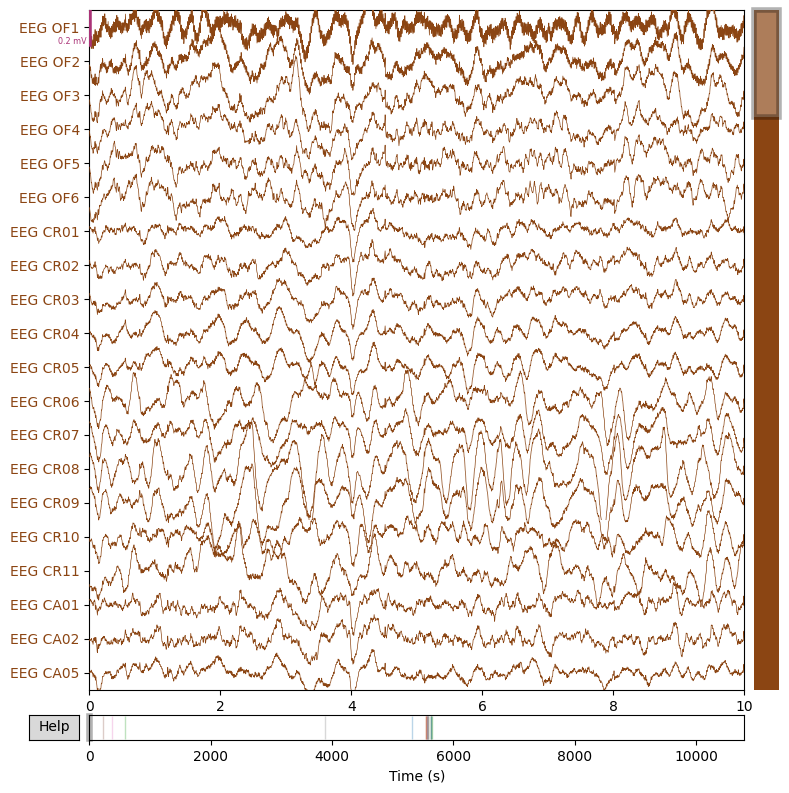

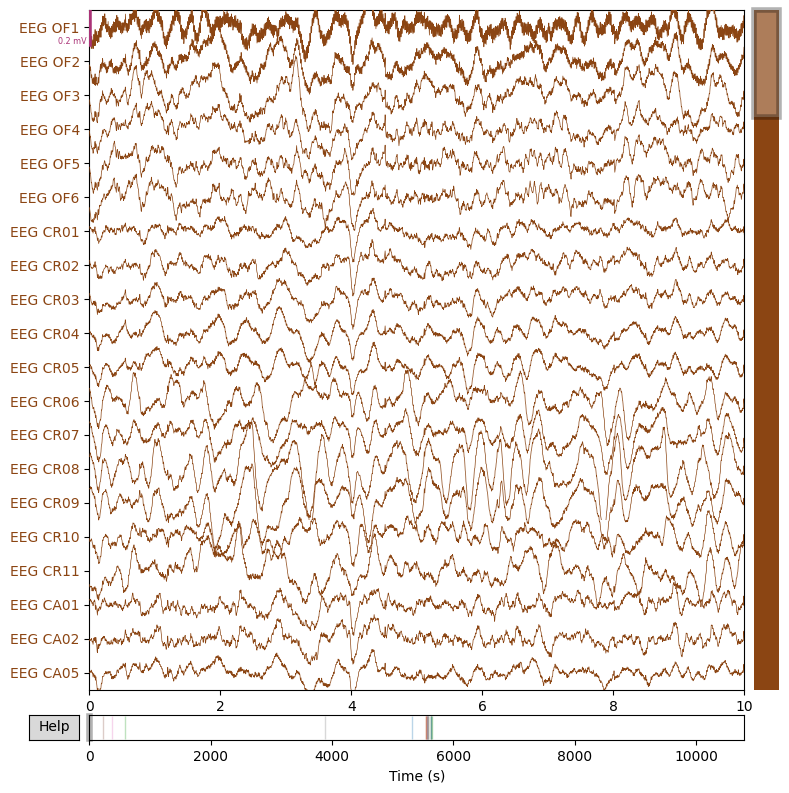

In [49]:
raw.plot()